## **classifying Tweets using: NLP**



In [9]:
! pip install Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# We can use counter to count the objects from collections
import collections
from collections import Counter
from nltk.stem import WordNetLemmatizer

In [11]:
import pickle

In [12]:
import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, Activation, RepeatVector, Bidirectional, LSTM, Dropout, Embedding
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from nltk.corpus import stopwords
# This allows to create individual objects from a bog of words
from nltk.tokenize import word_tokenize
# Lemmatizer helps to reduce words to the base formfrom nltk.stem import WordNetLemmatizer
# Ngrams allows to group words in common pairs or trigrams..etc
from nltk import ngrams


In [14]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [15]:
SEED = 10

In [16]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

#Get Head and info about the data

In [17]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


##Check For Null Data

In [20]:
percent_missing = df_train.isnull().sum() * 100 / len(df_train)
percent_missing

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [21]:
percent_missing = df_test.isnull().sum() * 100 / len(df_train)
percent_missing

id           0.000000
keyword      0.341521
location    14.514646
text         0.000000
dtype: float64

**As though from seeing the header data for train dataframe and test dataframe the most percentage of missing data is found in location data**

In [22]:
seriesf = df_train.groupby(['target'])['target'].count()
DF_target = pd.DataFrame({'Class':seriesf.index, 'Count':seriesf.values})

In [23]:
DF_target

,Class,Count
0,0,4342
1,1,3271


In [24]:
count_sum = DF_target['Count'].sum()

In [25]:
mean_dict = {}

for i in range(len(DF_target)):
  mean_dict[DF_target['Class'][i]]=(DF_target['Count'][i]/count_sum)*100

In [26]:
mean_dict

{0: 57.03402075397347, 1: 42.96597924602653}

**This Means that the text about the real disaster which has the class 1 is 42% in the train data and for not disaster is 57% of the train data is in that class**

##Check Data in Location/KeyWord Column

**Getting the 15 highest Location Found in data**

In [27]:
df_train.groupby(['location'])['location'].count().sort_values(ascending=False)[0:15]

location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Chicago, IL         18
Australia           18
Name: location, dtype: int64

***It is noticed that USA has the highest existence in data of location as seen(USA, New York, United States,....) 
this data may be baised more for the American Society mind***

**Getting the 15 highest Keywords**

In [28]:
df_train.groupby(['keyword'])['keyword'].count().sort_values(ascending=False)[0:15]

keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
Name: keyword, dtype: int64

##Get the distribution for the target Labels

Text(0.5, 1.0, 'Distribution of the Target Label')

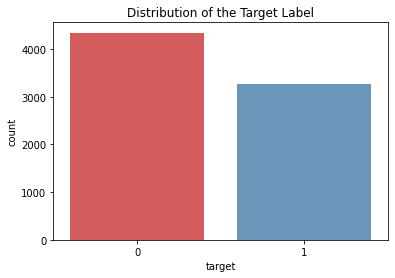

In [29]:
sns.countplot(x = df_train['target'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the Target Label')

In [30]:
def word_frequency(sentence):
  # joins all the sentenses
  sentence ="".join(sentence)
  # creates tokens, creates lower class, removes numbers and lemmatizes the words
  new_tokens = word_tokenize(sentence)
  new_tokens = [t.lower() for t in new_tokens]
  new_tokens_word =[t for t in new_tokens if t not in stopwords.words('english')]
  new_tokens_stword =[t for t in new_tokens if t in stopwords.words('english')]
  new_tokens_word = [t for t in new_tokens_word if t.isalpha()]
  new_tokens_stword = [t for t in new_tokens_stword if t.isalpha()]
  lemmatizer = WordNetLemmatizer()
  new_tokens_word =[lemmatizer.lemmatize(t) for t in new_tokens_word]
  new_tokens_stword = [lemmatizer.lemmatize(t) for t in new_tokens_stword]
  #counts the words, pairs and trigrams for both words and stop words
  counted = Counter(new_tokens_word)
  counted_stp = Counter(new_tokens_stword)
  #create data frequency dataframe
  word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
  word_freq_stp = pd.DataFrame(counted_stp.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
  return word_freq,word_freq_stp

In [31]:
a = word_frequency(df_train['text'])

In [32]:
a[0]

,word,frequency
125,http,4664
286,amp,344
118,like,341
8,fire,315
209,get,249
...,...,...
2668,doping,1
8080,ensure,1
2667,athletics,1
2665,thea,1


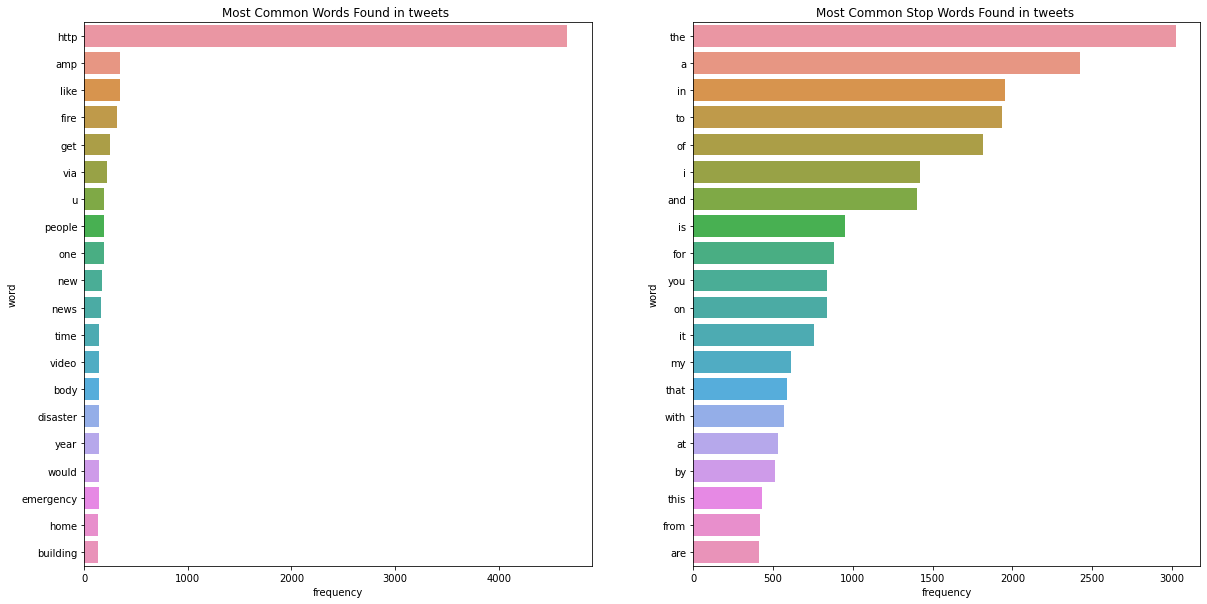

In [33]:
fig, axes = plt.subplots(1,2,figsize=(20,10))
sns.barplot(ax=axes[0],x='frequency',y='word',data=a[0].head(20))
sns.barplot(ax=axes[1],x='frequency',y='word',data=a[1].head(20))
axes[0].title.set_text('Most Common Words Found in tweets ')
axes[1].title.set_text('Most Common Stop Words Found in tweets ')

**As found the word "http" is the most common word found in the normal word which may give an indication that there are about tweets that contain links for some content -- the other is that the tweets contain low frequency of normal words in compare to stop words**

##Define Our Model

In [34]:
df_train.dropna(subset = ['text'], inplace = True)

X = df_train['text']
y = df_train['target']

**Define LSTM model**

In [35]:
def get_model():
    model = tf.keras.Sequential([
        Input(name='inputs',shape=[MAX_LEN]),
        Embedding(len(tok.word_index), 128),
        Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
        Bidirectional(tf.keras.layers.LSTM(64)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    #compile model
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    
    return model

**Divide data to train and test**

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = SEED)

In [37]:
#define Keras Tokenizer
MAX_LEN = 50

tok = Tokenizer()
tok.fit_on_texts(X_train)
#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)
#padded sequences
X_train_seq = sequence.pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences,maxlen=MAX_LEN)

#create the model
model = get_model()

In [38]:
import torch
import sklearn.metrics as metrics

In [39]:
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [40]:
#train model
history = model.fit(X_train_seq, y_train, epochs=50,
                    validation_split = 0.2, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=6, verbose=False,restore_best_weights=True)])


Epoch 1/50
153/153 [==============================] - 22s 27ms/step - loss: 0.6718 - accuracy: 0.5751 - val_loss: 0.6429 - val_accuracy: 0.6560
Epoch 2/50
153/153 [==============================] - 3s 19ms/step - loss: 0.5696 - accuracy: 0.7163 - val_loss: 0.4865 - val_accuracy: 0.7783
Epoch 3/50
153/153 [==============================] - 3s 18ms/step - loss: 0.3433 - accuracy: 0.8666 - val_loss: 0.4584 - val_accuracy: 0.7980
Epoch 4/50
153/153 [==============================] - 3s 18ms/step - loss: 0.1997 - accuracy: 0.9312 - val_loss: 0.5404 - val_accuracy: 0.7989
Epoch 5/50
153/153 [==============================] - 3s 18ms/step - loss: 0.1211 - accuracy: 0.9616 - val_loss: 0.6576 - val_accuracy: 0.7923
Epoch 6/50
153/153 [==============================] - 3s 18ms/step - loss: 0.0702 - accuracy: 0.9821 - val_loss: 0.8254 - val_accuracy: 0.7594
Epoch 7/50
153/153 [==============================] - 3s 18ms/step - loss: 0.0514 - accuracy: 0.9891 - val_loss: 0.8907 - val_accuracy: 0.775

In [41]:
y_pred =  model.predict(X_test_seq)

In [42]:
y_pred

array([[0.09621926],
       [0.9959489 ],
       [0.03981216],
       ...,
       [0.04054315],
       [0.05063611],
       [0.02575201]], dtype=float32)

In [43]:
y_pred = np.where(y_pred>=0.5,1,0)

In [44]:
y_pred

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [45]:
y_test

7081    1
2183    1
497     0
1915    0
1228    1
       ..
5928    0
6132    0
6160    1
536     0
920     0
Name: target, Length: 1523, dtype: int64

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       869
           1       0.79      0.70      0.74       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



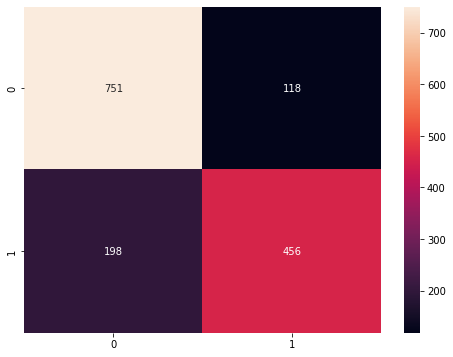

In [47]:
#confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='')

In [48]:
print('Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Precision  is : ', (metrics.precision_score(y_test, y_pred)))

Accuracy  is  :  0.7925147734734077
Recall  is    :  0.6972477064220184
Precision  is :  0.794425087108014


##Pickling Model Weights

In [49]:
weigh= model.get_weights();    pklfile= "/content/modelweights.pkl"
try:
    fpkl= open(pklfile, 'wb')    #Python 3     
    pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()
except:
    fpkl= open(pklfile, 'w')    #Python 2      
    pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()

In [50]:
# with open(r"/etc/modelweights.pkl", "rb") as input_file:
#        e = pickle.load(input_file)

In [51]:
# e